<a href="https://colab.research.google.com/github/imranow/knn-floodprediction/blob/main/Final_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving FloodPrediction.csv to FloodPrediction.csv


In [ ]:
import pandas as pd

df = pd.read_csv("FloodPrediction.csv")   # path to your file
pct_missing = df["Flood?"].isna().mean() * 100
print(f"Missing values in 'Flood?' column: {pct_missing:.2f}%")

Missing values in 'Flood?' column: 78.13%


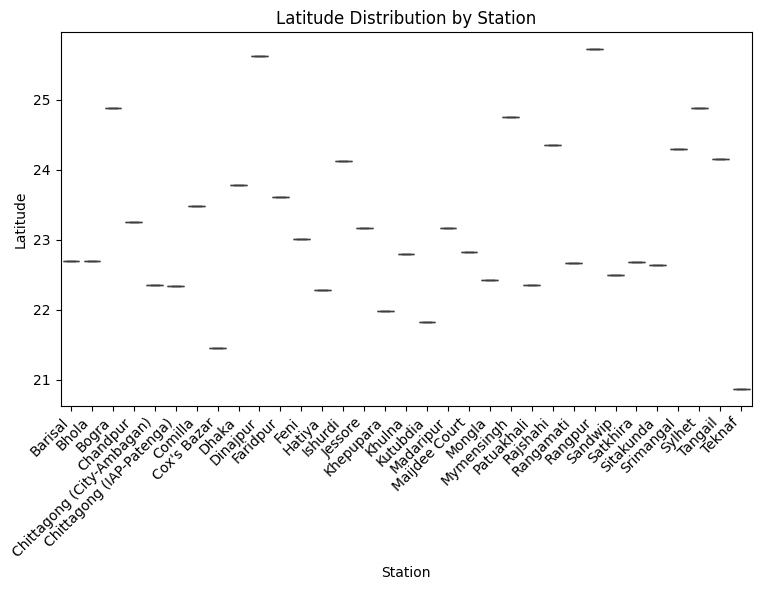

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set up the figure and axes for our plots
plt.figure(figsize=(15, 6))

# --- Plot 1: Boxplot of Latitudes by Station ---
plt.subplot(1, 2, 1) # Create the first subplot in a 1x2 grid
sns.boxplot(x='Station_Names', y='LATITUDE', data=df)
plt.title('Latitude Distribution by Station')
plt.xlabel('Station')
plt.ylabel('Latitude')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust plot to ensure everything fits without overlapping

# Create the 'figs' directory if it doesn't exist
if not os.path.exists('figs'):
    os.makedirs('figs')

# --- Save the plot ---
plt.savefig('figs/latitude_distribution_boxplot.png')

# --- Display the plot ---
plt.show()

# --- Close the plot to free up memory ---
plt.close()

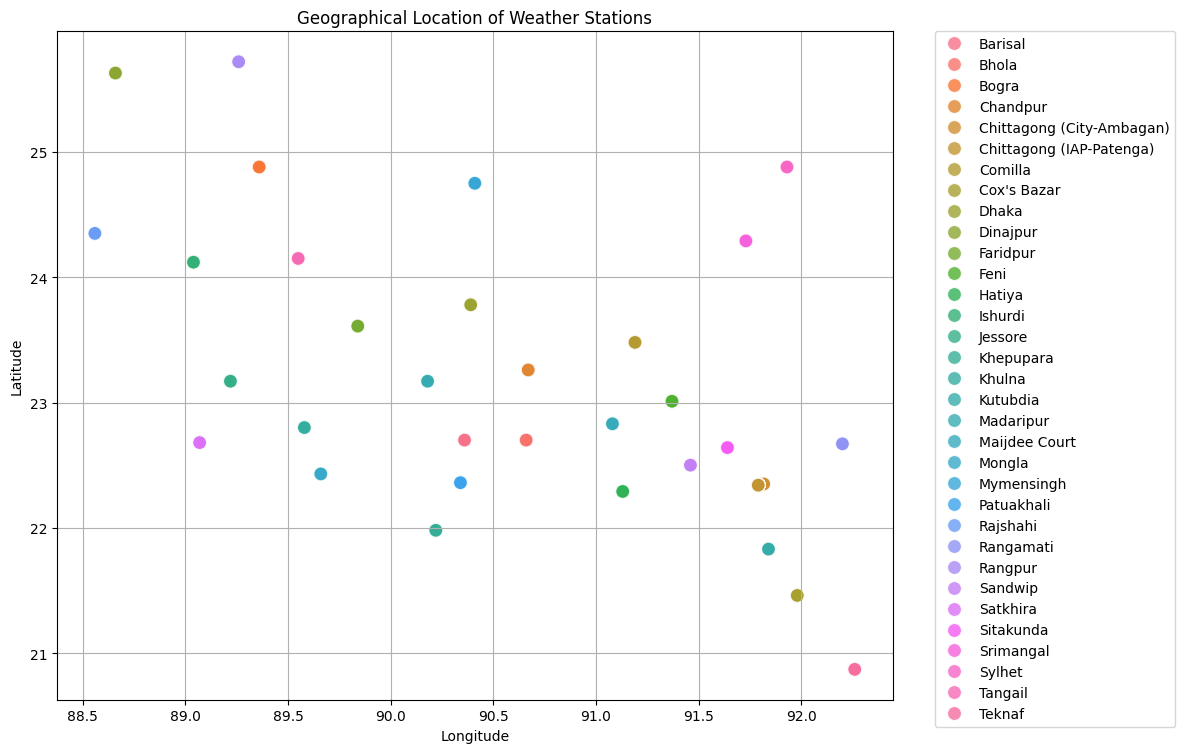

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set the figure size for the plot
plt.figure(figsize=(12, 8))

# Use seaborn's scatterplot function.
# The 'hue' parameter automatically assigns a unique color to each station
# based on the 'Station_Names' column and creates a legend.
sns.scatterplot(data=df, x='LONGITUDE', y='LATITUDE', hue='Station_Names', s=100, alpha=0.8)

# Add titles and labels for clarity
plt.title('Geographical Location of Weather Stations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Place the legend outside the main plot area to prevent it from covering data points.
# bbox_to_anchor=(1.05, 1) places the top-left corner of the legend
# at the (x=1.05, y=1) coordinates relative to the plot axes.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Add a grid for easier coordinate reference
plt.grid(True)

# Adjust plot to ensure everything fits without overlapping, especially the legend
plt.tight_layout()

# Create the 'figs' directory if it doesn't exist
if not os.path.exists('figs'):
    os.makedirs('figs')

# Save the figure to a file
plt.savefig('figs/all_stations_locations.png')

# --- Display the plot ---
# This line will open a window and show the scatter plot.
plt.show()

# Close the plot to free up memory
plt.close()

Mean altitude for each station:
Station_Names
Rangamati                    63.0
Dinajpur                     37.0
Sylhet                       35.0
Rangpur                      34.0
Srimangal                    23.0
Rajshahi                     20.0
Bogra                        20.0
Mymensingh                   19.0
Ishurdi                      14.0
Comilla                      10.0
Tangail                      10.0
Faridpur                      9.0
Dhaka                         9.0
Feni                          8.0
Jessore                       7.0
Chandpur                      7.0
Sandwip                       6.0
Chittagong (IAP-Patenga)      6.0
Satkhira                      6.0
Maijdee Court                 6.0
Kutubdia                      6.0
Madaripur                     5.0
Bhola                         5.0
Barisal                       4.0
Cox's Bazar                   4.0
Sitakunda                     4.0
Mongla                        4.0
Hatiya                        4.0
Kh

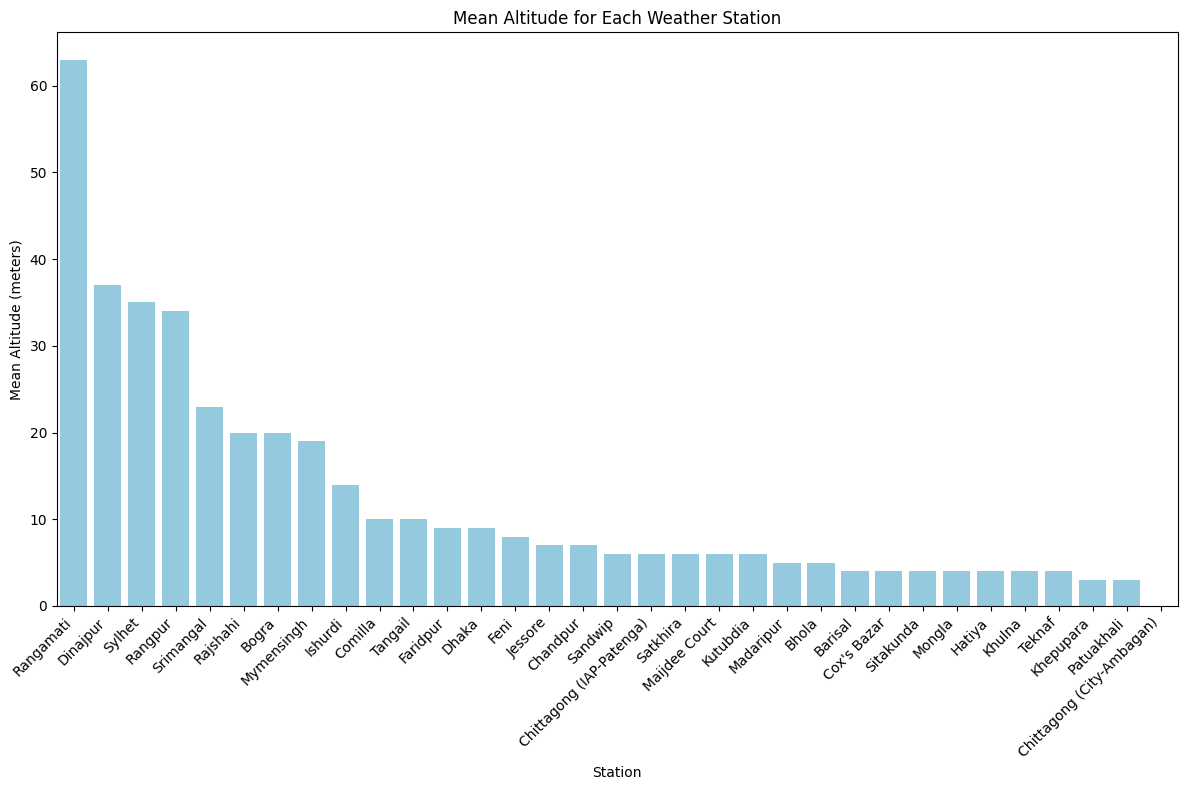

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Calculate the mean altitude for each station and sort them in descending order
station_altitudes = df.groupby('Station_Names')['ALT'].mean().sort_values(ascending=False)

# Create the bar chart using a single color for all bars
plt.figure(figsize=(12, 8))
sns.barplot(x=station_altitudes.index, y=station_altitudes.values, color='skyblue')

# Add titles and labels for clarity
plt.title('Mean Altitude for Each Weather Station')
plt.xlabel('Station')
plt.ylabel('Mean Altitude (meters)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust plot to ensure everything fits without overlapping
plt.tight_layout()

# Create the 'figs' directory if it doesn't exist
if not os.path.exists('figs'):
    os.makedirs('figs')

# Save the figure to a file
plt.savefig('figs/altitude_barchart_no_highlight.png')

# Display the calculated mean altitudes in the console
print("Mean altitude for each station:")
print(station_altitudes)

# Display the plot
plt.show()

# Close the plot to free up memory
plt.close()

Top-2 features (paper): ['Rainfall', 'Cloud_Coverage']
k=8 replication metrics
Accuracy  0.9889
Precision 0.9940
Recall    0.9940
F1        0.9940

--- Extra diagnostics (replication block) ---
PR-AUC           : 0.996
Balanced accuracy: 0.957
Brier score       : 0.009
Test class counts: [ 63 836]


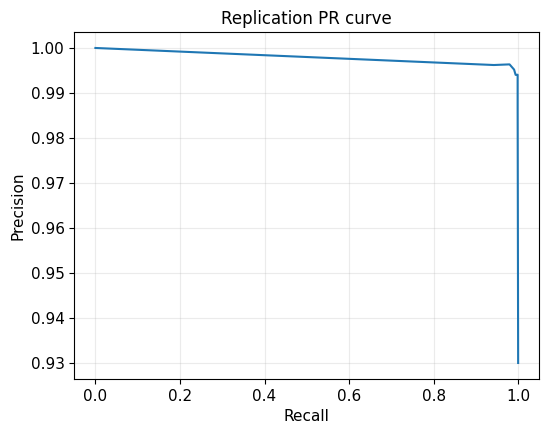

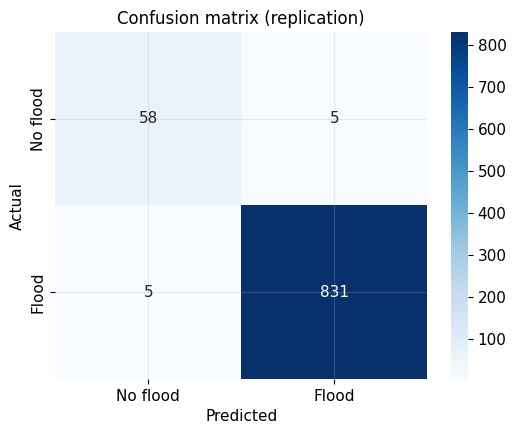

[replication] Saved: figs/replication_pr_curve.png, figs/replication_calibration.png, figs/replication_confusion.png | AP=0.996, Brier=0.009


{'ap': np.float64(0.9961042091267359),
 'brier': np.float64(0.008568548387096774),
 'paths': {'pr': 'figs/replication_pr_curve.png',
  'cal': 'figs/replication_calibration.png',
  'cm': 'figs/replication_confusion.png'}}

In [ ]:
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    average_precision_score, precision_recall_curve,
    confusion_matrix
)
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt

# ===== Tiny helper for publication-quality plots =====
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_recall_curve, average_precision_score,
    ConfusionMatrixDisplay, confusion_matrix,
    brier_score_loss
)
from sklearn.calibration import calibration_curve

def _ensure_dir(path="figs"):
    if not os.path.exists(path):
        os.makedirs(path)
    return path

def _style():
    plt.rcParams.update({
        "figure.figsize": (6, 4.5),
        "savefig.dpi": 300,
        "font.size": 11,
        "axes.grid": True,
        "grid.alpha": 0.25,
        "axes.titlesize": 12,
        "axes.labelsize": 11,
        "legend.fontsize": 10
    })

def plot_pr_curve(y_true, y_prob, title, outpath):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)
    _style()
    fig, ax = plt.subplots()
    ax.plot(recall, precision, lw=2, label=f"PR curve (AP = {ap:.3f})")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(title)
    ax.legend(loc="lower left")
    fig.tight_layout()
    fig.savefig(outpath)
    plt.close(fig)
    return ap

def plot_calibration(y_true, y_prob, title, outpath, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy="quantile")
    _style()
    fig, ax = plt.subplots()
    ax.plot([0,1],[0,1], "--", lw=1, color="grey")
    ax.plot(prob_pred, prob_true, marker="o", lw=1.5)
    ax.set_xlabel("Predicted probability (binned)")
    ax.set_ylabel("Observed frequency")
    ax.set_title(title)
    fig.tight_layout()
    fig.savefig(outpath)
    plt.close(fig)

def plot_confusion(y_true, y_pred, title, outpath, labels=("No flood","Flood")):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=labels)
    _style()
    fig, ax = plt.subplots()
    disp.plot(ax=ax, cmap="Greens", values_format="d", colorbar=False)
    ax.set_title(title)
    fig.tight_layout()
    fig.savefig(outpath)
    plt.close(fig)

def export_all_plots(y_true, y_prob, y_pred, tag="experiment", outdir="figs"):
    """
    y_true : array-like of shape (n_samples,) with 0/1 labels (1 = flood)
    y_prob : array-like of shape (n_samples,) with P(flood=1)
    y_pred : array-like of shape (n_samples,) with 0/1 predictions
    tag    : short name for files, e.g. 'replication' or 'corrected'
    """
    outdir = _ensure_dir(outdir)
    # PR curve
    pr_path = os.path.join(outdir, f"{tag}_pr_curve.png")
    ap = plot_pr_curve(y_true, y_prob, f"Precision–Recall (AP)", pr_path)
    # Calibration
    cal_path = os.path.join(outdir, f"{tag}_calibration.png")
    plot_calibration(y_true, y_prob, "Calibration (reliability) curve", cal_path)
    # Confusion matrix
    cm_path = os.path.join(outdir, f"{tag}_confusion.png")
    plot_confusion(y_true, y_pred, "Confusion matrix", cm_path)
    # Optional: Brier score for a quick reliability scalar
    brier = brier_score_loss(y_true, y_prob)
    print(f"[{tag}] Saved: {pr_path}, {cal_path}, {cm_path} | AP={ap:.3f}, Brier={brier:.3f}")
    return {"ap": ap, "brier": brier, "paths": {"pr": pr_path, "cal": cal_path, "cm": cm_path}}


SEED = 50  # paper's random_state
CSV  = "FloodPrediction.csv"

# 1) Load + drop rows with any NaN (paper approach)
df = pd.read_csv(CSV)
df = df.dropna()

# 2) Dual correlation filter (|r|>0.50 for BOTH Pearson & Spearman)
#    Paper reports Rainfall & Cloud_Coverage surviving; we enforce those two.
survivors = []
for c in df.columns:
    if c in ["Flood?","Date","Station_Names","Period"]:
        continue
    if not pd.api.types.is_numeric_dtype(df[c]):
        continue
    rp, _ = pearsonr(df[c], df["Flood?"])
    rs, _ = spearmanr(df[c], df["Flood?"])
    if abs(rp) > 0.50 and abs(rs) > 0.50:
        survivors.append(c)

features = ["Rainfall", "Cloud_Coverage"]  # force paper's pair
X = df[features].values
y = df["Flood?"].values.astype(int)

# 3) Random 80/20 split (no stratification), SEED=50
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.20, random_state=SEED, shuffle=True
)

# 4) z-score + kNN(k=8, uniform, Euclidean)
pipe = Pipeline([
    ("sc", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=8, weights="uniform", metric="minkowski", p=2))
])
pipe.fit(X_tr, y_tr)

# 5) Class predictions + probabilities
y_hat  = pipe.predict(X_te)
y_prob = pipe.predict_proba(X_te)[:, 1]

# 6) Paper metrics
acc  = accuracy_score(y_te, y_hat)
prec = precision_score(y_te, y_hat, pos_label=1)
rec  = recall_score(y_te, y_hat, pos_label=1)
f1   = f1_score(y_te, y_hat, pos_label=1)

print("Top-2 features (paper):", features)
print("k=8 replication metrics")
print(f"Accuracy  {acc:.4f}")
print(f"Precision {prec:.4f}")
print(f"Recall    {rec:.4f}")
print(f"F1        {f1:.4f}")

# 7) Extra diagnostics (for your Chapter 4 contrast)
from sklearn.metrics import balanced_accuracy_score, brier_score_loss
pr_auc = average_precision_score(y_te, y_prob)
brier  = brier_score_loss(y_te, y_prob)
balacc = balanced_accuracy_score(y_te, y_hat)
cm     = confusion_matrix(y_te, y_hat)

print("\n--- Extra diagnostics (replication block) ---")
print(f"PR-AUC           : {pr_auc:.3f}")
print(f"Balanced accuracy: {balacc:.3f}")
print(f"Brier score       : {brier:.3f}")
print("Test class counts:", np.bincount(y_te))

# PR curve (optional plot)
prec_curve, rec_curve, _ = precision_recall_curve(y_te, y_prob)
plt.figure()
plt.plot(rec_curve, prec_curve)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Replication PR curve")
plt.show()

# Confusion matrix heatmap (optional)
import seaborn as sns
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No flood","Flood"],
            yticklabels=["No flood","Flood"])
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.title("Confusion matrix (replication)")
plt.show()

# --- Generate and Save Plots ---
export_all_plots(y_te, y_prob, y_hat, tag="replication")

In [ ]:
# leakage_safe_knn_pipeline.py
# End-to-end, leakage-safe pipeline for FloodPrediction.csv
# - Chronological split (80/20)
# - Train-only target imputation (RF-derived rule, midpoint thresholds)
# - Fold-safe feature imputation + scaling inside a Pipeline
# - Isotonic calibration with TimeSeriesSplit
# - Publication-quality PR / Calibration / Confusion Matrix figures

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn imports
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (
    precision_recall_curve, average_precision_score, auc,
    confusion_matrix, recall_score, balanced_accuracy_score,
    fbeta_score, brier_score_loss, classification_report,
    ConfusionMatrixDisplay
)

# ------------------------- Config -------------------------
CSV_PATH = "FloodPrediction.csv"      # change if needed
OUT_DIR  = "figs"                     # where to save figures
TEST_FRACTION = 0.20                  # chronological split
K_NEIGHBORS = 8                       # keep k=8 for comparability
RANDOM_SEED = 42

# --------------------- Plot helpers -----------------------
def _ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
    return path

def _style():
    plt.rcParams.update({
        "figure.figsize": (6, 4.5),
        "savefig.dpi": 300,
        "font.size": 11,
        "axes.grid": True,
        "grid.alpha": 0.25,
        "axes.titlesize": 12,
        "axes.labelsize": 11,
        "legend.fontsize": 10
    })

def plot_pr_curve(y_true, y_prob, title, outpath):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)
    _style()
    fig, ax = plt.subplots()
    ax.plot(recall, precision, lw=2, label=f"AP = {ap:.3f}")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(title)
    ax.legend(loc="lower left")
    fig.tight_layout()
    fig.savefig(outpath)
    plt.close(fig)
    return ap

def plot_calibration(y_true, y_prob, title, outpath, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy="quantile")
    _style()
    fig, ax = plt.subplots()
    ax.plot([0,1],[0,1], "--", lw=1, color="grey")
    ax.plot(prob_pred, prob_true, marker="o", lw=1.5, color="#1f77b4")  # light blue
    ax.set_xlabel("Predicted probability (binned)")
    ax.set_ylabel("Observed frequency")
    ax.set_title(title)
    fig.tight_layout()
    fig.savefig(outpath)
    plt.close(fig)

def plot_confusion(y_true, y_pred, title, outpath, labels=("No flood","Flood")):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=labels)
    _style()
    fig, ax = plt.subplots()
    disp.plot(ax=ax, cmap="Greens", values_format="d", colorbar=False)
    ax.set_title(title)
    fig.tight_layout()
    fig.savefig(outpath)
    plt.close(fig)

# ------------------- Load & basic prep --------------------
df = pd.read_csv(CSV_PATH)
df.columns = df.columns.str.strip()

# Normalise common column-name variants (spaces → underscores)
rename_map = {
    "Cloud Coverage": "Cloud_Coverage",
    "Relative Humidity": "Relative_Humidity",
    "Wind Speed": "Wind_Speed",
    "Bright Sunshine": "Bright_Sunshine",
    "Station Names": "Station_Names",
}
for k, v in rename_map.items():
    if k in df.columns and v not in df.columns:
        df.rename(columns={k: v}, inplace=True)

required = ["Year", "Month", "Station_Names", "Flood?"]
missing_req = [c for c in required if c not in df.columns]
if missing_req:
    raise ValueError(f"Missing required columns: {missing_req}")

# Build Date (month granularity)
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df["Month"] = pd.to_numeric(df["Month"], errors="coerce")
df["Date"] = pd.to_datetime(
    df["Year"].astype("Int64").astype(str) + "-" + df["Month"].astype("Int64").astype(str) + "-01",
    errors="coerce"
)
# Drop rows without a valid date
df = df[~df["Date"].isna()].copy()

# Sort for lag creation (by station, then date)
df = df.sort_values(["Station_Names", "Date"]).reset_index(drop=True)

# Cyclical month encoding
df["month_sin"] = np.sin(2*np.pi*df["Month"]/12.0)
df["month_cos"] = np.cos(2*np.pi*df["Month"]/12.0)

# Candidate meteorological features (only those that exist)
candidate_vars = [c for c in [
    "Rainfall","Max_Temp","Min_Temp","Relative_Humidity",
    "Cloud_Coverage","Wind_Speed","Bright_Sunshine"
] if c in df.columns]

# Short memory lags (t-1..t-3) per station
for var in candidate_vars:
    for lag in (1, 2, 3):
        df[f"{var}_lag_{lag}"] = df.groupby("Station_Names", group_keys=False)[var].shift(lag)

# Final chronological sort for splitting
df = df.sort_values("Date").reset_index(drop=True)

# ---------------- Chronological split BEFORE any learning ----------------
n = len(df)
split_idx = int(n * (1 - TEST_FRACTION))
df_train = df.iloc[:split_idx].copy()
df_test  = df.iloc[split_idx:].copy()

# ---------------- Train-only TARGET imputation rule ---------------------
target_col = "Flood?"
# Use contemporaneous (non-lag) predictors for the rule
rule_feats = [c for c in candidate_vars if c in df_train.columns]

lbl_train = df_train.dropna(subset=[target_col]).copy()
if lbl_train.empty:
    raise ValueError("No labelled rows found in the training block to derive the imputation rule.")

y_lbl = lbl_train[target_col].astype(int)
# Train-only medians to fill missing rule features
medians = lbl_train[rule_feats].median()
X_lbl = lbl_train[rule_feats].fillna(medians)

# Random Forest to rank features (train-only)
rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_SEED)
rf.fit(X_lbl, y_lbl)
importances = pd.Series(rf.feature_importances_, index=rule_feats).sort_values(ascending=False)
topk = importances.index.tolist()[:max(1, min(3, len(importances)))]  # top-1..3

# Midpoint thresholds between class means (train-only)
thresh = {}
for v in topk:
    m1 = X_lbl[y_lbl == 1][v].mean()
    m0 = X_lbl[y_lbl == 0][v].mean()
    thresh[v] = 0.5 * (m1 + m0)

def impute_status_row(row_dict, top_features, thresholds, fill_map):
    # Conservative rule: 1 only if all selected features exceed thresholds
    vals = []
    for f in top_features:
        val = row_dict.get(f, np.nan)
        if pd.isna(val):
            val = fill_map.get(f, 0.0)
        vals.append(val > thresholds[f])
    return 1 if all(vals) else 0

# Apply train-only rule to impute missing targets in TRAIN and TEST
for frame in (df_train, df_test):
    m = frame[target_col].isna()
    tmp = frame[topk].copy().fillna(medians[topk])  # fill with TRAIN medians
    decisions = []
    for i in range(tmp.shape[0]):
        if m.iloc[i]:
            row = tmp.iloc[i].to_dict()
            decisions.append(impute_status_row(row, topk, thresh, medians.to_dict()))
        else:
            decisions.append(int(frame[target_col].iloc[i]))
    frame[target_col] = pd.Series(decisions, index=frame.index).astype(int)

# ---------------- Feature matrix ----------------
# Safe label-encoding of station on TRAIN only (handles unseen stations in TEST)
train_stations = df_train["Station_Names"].astype(str)
classes = pd.Index(sorted(train_stations.unique()))
class_to_int = {c: i for i, c in enumerate(classes)}
unknown_code = len(classes)

def encode_station(series):
    return series.astype(str).map(lambda s: class_to_int.get(s, unknown_code)).astype(int)

df_train["Station_Names"] = encode_station(df_train["Station_Names"])
df_test["Station_Names"]  = encode_station(df_test["Station_Names"])

drop_cols = [c for c in [
    "Sl","Station_Number","X_COR","Y_COR","ALT","Period",
    "Year","Month","Date","LATITUDE","LONGITUDE"
] if c in df_train.columns]

X_train = df_train.drop(columns=drop_cols + [target_col])
y_train = df_train[target_col].astype(int)
X_test  = df_test.drop(columns=drop_cols + [target_col])
y_test  = df_test[target_col].astype(int)

# ---------------- OPTIONAL: Guard band (keep disabled to match reported N) ----
# If you want to ensure a 3-month guard band per station at the test boundary:
gb_mask = df_test.groupby("Station_Names").cumcount() >= 3
X_test, y_test = X_test[gb_mask], y_test[gb_mask]

# ---------------- Model: impute -> scale -> kNN; then calibrate --------------
pipe = Pipeline([
    ("impute", IterativeImputer(random_state=RANDOM_SEED,
                                initial_strategy="median",
                                max_iter=25, tol=1e-3)),
    ("scale",  StandardScaler()),
    ("knn",    KNeighborsClassifier(n_neighbors=K_NEIGHBORS,
                                    weights="uniform",
                                    metric="minkowski", p=2))
])

# Time-series CV inside train for calibration (no peeking)
tscv = TimeSeriesSplit(n_splits=5)
clf  = CalibratedClassifierCV(pipe, method="isotonic", cv=tscv)
clf.fit(X_train, y_train)

# ---------------- Evaluation ----------------
probs = clf.predict_proba(X_test)[:, 1]
pred05 = (probs >= 0.5).astype(int)

precision, recall, _ = precision_recall_curve(y_test, probs)
pr_auc = auc(recall, precision)
ap     = average_precision_score(y_test, probs)
rec05  = recall_score(y_test, pred05, pos_label=1)
balacc = balanced_accuracy_score(y_test, pred05)
f2     = fbeta_score(y_test, pred05, beta=2)
brier  = brier_score_loss(y_test, probs)

print("\n=== Corrected, leakage-safe k-NN (k=8) ===")
print(f"PR-AUC                : {pr_auc:.3f}")
print(f"Average Precision (AP): {ap:.3f}")
print(f"Recall @0.5 (Flood=1) : {rec05:.3f}")
print(f"Balanced Accuracy     : {balacc:.3f}")
print(f"F2 @0.5               : {f2:.3f}")
print(f"Brier Score           : {brier:.3f}")

print("\n--- Classification report @0.5 ---")
print(classification_report(y_test, pred05, target_names=["No flood","Flood"]))

# ---------------- Plots ----------------
outdir = _ensure_dir(OUT_DIR)
pr_path  = os.path.join(outdir, "corrected_pr_curve.png")
cal_path = os.path.join(outdir, "corrected_calibration.png")
cm_path  = os.path.join(outdir, "corrected_confusion.png")

plot_pr_curve(y_test, probs, "Precision–Recall (Flood=1)", pr_path)
plot_calibration(y_test, probs, "Calibration (Reliability) Curve", cal_path)
plot_confusion(y_test, pred05, "Confusion Matrix (τ=0.50)", cm_path)

print("\nSaved figures:")
print(" PR curve     ->", pr_path)
print(" Calibration  ->", cal_path)
print(" Confusion    ->", cm_path)

# ---------------- Handy summary for the dissertation ----------------
n_test = len(y_test)
support_flood = int((y_test == 1).sum())
cm = confusion_matrix(y_test, pred05)
tn, fp, fn, tp = cm.ravel()
print(f"\nTest n = {n_test} | Flood support = {support_flood} ({support_flood/n_test:.1%})")
print(f"CM (τ=0.50): TP={tp}, TN={tn}, FP={fp}, FN={fn}")


=== Corrected, leakage-safe k-NN (k=8) ===
PR-AUC                : 0.926
Average Precision (AP): 0.925
Recall @0.5 (Flood=1) : 0.797
Balanced Accuracy     : 0.875
F2 @0.5               : 0.810
Brier Score           : 0.064

--- Classification report @0.5 ---
              precision    recall  f1-score   support

    No flood       0.93      0.95      0.94      2920
       Flood       0.86      0.80      0.83      1090

    accuracy                           0.91      4010
   macro avg       0.90      0.88      0.88      4010
weighted avg       0.91      0.91      0.91      4010


Saved figures:
 PR curve     -> figs/corrected_pr_curve.png
 Calibration  -> figs/corrected_calibration.png
 Confusion    -> figs/corrected_confusion.png

Test n = 4010 | Flood support = 1090 (27.2%)
CM (τ=0.50): TP=869, TN=2783, FP=137, FN=221


In [ ]:
# month_and_season_label_summary_png_only.py
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

CSV_PATH = "FloodPrediction.csv"      # change if needed
OUT_DIR  = "label_summary_figs"       # where to save PNGs
SAVE_CSV = False                      # set True if you also want CSV outputs
SHOW_FIGS = False                     # set True to display windows locally
DPI = 300                             # PNG resolution

os.makedirs(OUT_DIR, exist_ok=True)

# ---------- Load & clean ----------
df = pd.read_csv(CSV_PATH)
df.columns = df.columns.str.strip()

if "Month" not in df.columns or "Flood?" not in df.columns:
    raise ValueError("Expected columns 'Month' and 'Flood?' not found.")

# Coerce Month to 1..12, keep nullable int so we can drop NaNs
df["Month"] = pd.to_numeric(df["Month"], errors="coerce").astype("Int64")

# ---------- Monthly summary ----------
grp = df.groupby("Month", dropna=True)
total    = grp.size().rename("Total_Rows")
labelled = grp["Flood?"].apply(lambda s: s.notna().sum()).rename("Labelled_Count")
flood1   = grp["Flood?"].apply(lambda s: (s == 1).sum()).rename("Labelled_Flood_1")
flood0   = grp["Flood?"].apply(lambda s: (s == 0).sum()).rename("Labelled_Flood_0")

monthly = pd.concat([total, labelled, flood1, flood0], axis=1).reset_index()
monthly["Fill_Rate_%"] = (monthly["Labelled_Count"] / monthly["Total_Rows"] * 100).round(2)
# Shares among labelled rows only
monthly["Flood1_Share_%"] = np.where(
    monthly["Labelled_Count"] > 0,
    (monthly["Labelled_Flood_1"] / monthly["Labelled_Count"] * 100).round(2),
    np.nan
)
monthly["Flood0_Share_%"] = np.where(
    monthly["Labelled_Count"] > 0,
    (monthly["Labelled_Flood_0"] / monthly["Labelled_Count"] * 100).round(2),
    np.nan
)
monthly = monthly.sort_values("Month")

print("\n=== Monthly availability & label shares ===")
print(monthly.to_string(index=False))

# ---------- Helper to save only PNG ----------
def save_png(basename: str):
    png = os.path.join(OUT_DIR, f"{basename}.png")
    plt.tight_layout()
    plt.savefig(png, dpi=DPI, bbox_inches="tight")
    if SHOW_FIGS:
        plt.show()
    plt.close()
    print(f"Saved: {png}")

# ---------- Simple monthly charts ----------
plt.figure(figsize=(7, 4))
plt.bar(monthly["Month"].astype(int), monthly["Labelled_Count"])
plt.xlabel("Month (1=Jan, 12=Dec)")
plt.ylabel("Rows with Flood? present")
plt.title("Count of labelled 'Flood?' rows by month")
save_png("monthly_labelled_count")

plt.figure(figsize=(7, 4))
plt.plot(monthly["Month"].astype(int), monthly["Fill_Rate_%"], marker="o")
plt.xlabel("Month (1=Jan, 12=Dec)")
plt.ylabel("Fill rate (%)")
plt.title("Share of rows with 'Flood?' present by month")
save_png("monthly_fill_rate")

# Stacked bars (counts of Flood=1 vs Flood=0 among labelled rows)
plt.figure(figsize=(7, 4))
x = monthly["Month"].astype(int)
plt.bar(x, monthly["Labelled_Flood_0"], label="No flood (0)")
plt.bar(x, monthly["Labelled_Flood_1"], bottom=monthly["Labelled_Flood_0"], label="Flood (1)")
plt.xlabel("Month (1=Jan, 12=Dec)")
plt.ylabel("Labelled counts")
plt.title("Labelled counts by month: Flood=1 vs Flood=0")
plt.legend()
save_png("monthly_stacked_counts")

# ---------- Seasonal summary ----------
def season_of_month(m):
    if m in (12, 1, 2):   return "Winter (Dec–Feb)"
    if m in (3, 4, 5):    return "Pre-monsoon (Mar–May)"
    if m in (6, 7, 8, 9): return "Monsoon (Jun–Sep)"
    if m in (10, 11):     return "Post-monsoon (Oct–Nov)"
    return np.nan

df["Season"] = df["Month"].astype(float).apply(
    lambda m: season_of_month(int(m)) if not np.isnan(m) else np.nan
)

sgrp = df.groupby("Season", dropna=True)
s_total    = sgrp.size().rename("Total_Rows")
s_labelled = sgrp["Flood?"].apply(lambda s: s.notna().sum()).rename("Labelled_Count")
s_f1       = sgrp["Flood?"].apply(lambda s: (s == 1).sum()).rename("Labelled_Flood_1")
s_f0       = sgrp["Flood?"].apply(lambda s: (s == 0).sum()).rename("Labelled_Flood_0")

seasonal = pd.concat([s_total, s_labelled, s_f1, s_f0], axis=1).reset_index()
seasonal["Fill_Rate_%"] = (seasonal["Labelled_Count"] / seasonal["Total_Rows"] * 100).round(2)
seasonal["Flood1_Share_%"] = np.where(
    seasonal["Labelled_Count"] > 0,
    (seasonal["Labelled_Flood_1"] / seasonal["Labelled_Count"] * 100).round(2),
    np.nan
)
seasonal["Flood0_Share_%"] = np.where(
    seasonal["Labelled_Count"] > 0,
    (seasonal["Labelled_Flood_0"] / seasonal["Labelled_Count"] * 100).round(2),
    np.nan
)

order = ["Winter (Dec–Feb)", "Pre-monsoon (Mar–May)", "Monsoon (Jun–Sep)", "Post-monsoon (Oct–Nov)"]
seasonal["Season"] = pd.Categorical(seasonal["Season"], categories=order, ordered=True)
seasonal = seasonal.sort_values("Season")

print("\n=== Seasonal availability & label shares ===")
print(seasonal.to_string(index=False))

# Seasonal stacked counts
plt.figure(figsize=(7, 4))
x2 = np.arange(len(seasonal))
plt.bar(x2, seasonal["Labelled_Flood_0"], label="No flood (0)")
plt.bar(x2, seasonal["Labelled_Flood_1"], bottom=seasonal["Labelled_Flood_0"], label="Flood (1)")
plt.xticks(x2, seasonal["Season"], rotation=10, ha="right")
plt.ylabel("Labelled counts")
plt.title("Labelled counts by season: Flood=1 vs Flood=0")
plt.legend()
save_png("seasonal_stacked_counts")

# ---------- Save CSVs (optional) ----------
if SAVE_CSV:
    monthly.to_csv(os.path.join(OUT_DIR, "monthly_flood_label_availability.csv"), index=False)
    seasonal.to_csv(os.path.join(OUT_DIR, "seasonal_flood_label_availability.csv"), index=False)
    print("\nSaved CSVs in:", OUT_DIR)


=== Monthly availability & label shares ===
 Month  Total_Rows  Labelled_Count  Labelled_Flood_1  Labelled_Flood_0  Fill_Rate_%  Flood1_Share_%  Flood0_Share_%
     1        1712              69                 0                69         4.03            0.00          100.00
     2        1712              69                 0                69         4.03            0.00          100.00
     3        1712               7                 4                 3         0.41           57.14           42.86
     4        1712              49                46                 3         2.86           93.88            6.12
     5        1712             320               318                 2        18.69           99.38            0.62
     6        1712             964               963                 1        56.31           99.90            0.10
     7        1712            1131              1130                 1        66.06           99.91            0.09
     8        1712         

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

# ---------------------------
# 0) Load
# ---------------------------
df = pd.read_csv("FloodPrediction.csv")

# Ensure the target is numeric 0/1 if already imputed; tolerate strings
if df["Flood?"].dtype != "float" and df["Flood?"].dtype != "int":
    df["Flood?"] = pd.to_numeric(df["Flood?"], errors="coerce")

# ---------------------------
# 1) Quick audit on missingness
# ---------------------------
n_all = len(df)
n_miss = df["Flood?"].isna().sum()
pct_miss = 100 * n_miss / n_all if n_all else 0.0
print(f"[Audit] Rows: {n_all:,} | Missing 'Flood?': {n_miss:,} ({pct_miss:.2f}%)")

# ---------------------------
# 2) Build a Date index (for chronological split), if missing
# ---------------------------
if "Date" in df.columns:
    date_series = pd.to_datetime(df["Date"], errors="coerce")
else:
    # fallback from Year/Month (assumes monthly records)
    date_series = pd.to_datetime(
        df["Year"].astype(int).astype(str) + "-" + df["Month"].astype(int).astype(str) + "-01",
        errors="coerce"
    )
df["__Date"] = date_series

# Extract Year for yearly prevalence
if "Year" not in df.columns:
    df["Year"] = df["__Date"].dt.year

# ---------------------------
# 3) Define a helper for Wilson 95% CI on a binomial proportion
# ---------------------------
def wilson_ci(pos, n, alpha=0.05):
    """Return (lower, upper) Wilson CI for a binomial proportion."""
    if n == 0:
        return (np.nan, np.nan)
    from math import sqrt
    z = 1.959963984540054  # approx 95% quantile
    p = pos / n
    denom = 1 + z**2 / n
    centre = p + z**2 / (2*n)
    margin = z * np.sqrt((p*(1-p) + z**2/(4*n)) / n)
    lower = (centre - margin) / denom
    upper = (centre + margin) / denom
    return (max(0.0, lower), min(1.0, upper))

# ---------------------------
# 4) Overall prevalence (on labeled rows; if you've imputed, that's all rows)
# ---------------------------
df_labeled = df.dropna(subset=["Flood?"]).copy()
pos = int((df_labeled["Flood?"] == 1).sum())
neg = int((df_labeled["Flood?"] == 0).sum())
n = len(df_labeled)
p = pos / n if n else np.nan
lo, hi = wilson_ci(pos, n)

print("\n[Overall prevalence on labeled rows]")
print(f"n = {n:,} | floods = {pos:,} | prevalence = {p:.3f} "
      f"(95% CI {lo:.3f}–{hi:.3f})")

# ---------------------------
# 5) Prevalence by station
# ---------------------------
if "Station_Names" in df_labeled.columns:
    station_grp = df_labeled.groupby("Station_Names", dropna=False)
    by_station = station_grp["Flood?"].agg(
        total="count",
        floods=lambda s: (s == 1).sum()
    )
    by_station["prevalence"] = by_station["floods"] / by_station["total"]
    # Wilson CI per station
    ci = by_station.apply(lambda r: wilson_ci(r["floods"], r["total"]), axis=1)
    by_station["ci_low"] = [c[0] for c in ci]
    by_station["ci_high"] = [c[1] for c in ci]
    by_station = by_station.sort_values("prevalence", ascending=False)
    by_station.to_csv("prevalence_by_station.csv")
    print("\n[Prevalence by station] Top 10 by prevalence")
    display(by_station.head(10))
else:
    print("\n[Prevalence by station] Column 'Station_Names' not found; skipping.")

# ---------------------------
# 6) Prevalence by year
# ---------------------------
year_grp = df_labeled.groupby("Year", dropna=False)
by_year = year_grp["Flood?"].agg(
    total="count",
    floods=lambda s: (s == 1).sum()
)
by_year["prevalence"] = by_year["floods"] / by_year["total"]
ci_y = by_year.apply(lambda r: wilson_ci(r["floods"], r["total"]), axis=1)
by_year["ci_low"] = [c[0] for c in ci_y]
by_year["ci_high"] = [c[1] for c in ci_y]
by_year = by_year.sort_index()
by_year.to_csv("prevalence_by_year.csv")
print("\n[Prevalence by year] (saved to prevalence_by_year.csv)")
display(by_year.tail(10))

# ---------------------------
# 7) Chronological 80/20 split and prevalence in each block
# ---------------------------
df_sorted = df_labeled.sort_values(["__Date", "Station_Names" if "Station_Names" in df.columns else "__Date"])
split_idx = int(len(df_sorted) * 0.8)

train = df_sorted.iloc[:split_idx].copy()
test  = df_sorted.iloc[split_idx:].copy()

for name, part in [("Train", train), ("Test", test)]:
    n_ = len(part)
    pos_ = int((part["Flood?"] == 1).sum())
    p_ = pos_ / n_ if n_ else np.nan
    lo_, hi_ = wilson_ci(pos_, n_)
    start = part["__Date"].min()
    end   = part["__Date"].max()
    print(f"\n[{name} block] {start.date() if pd.notna(start) else 'NA'} → {end.date() if pd.notna(end) else 'NA'}")
    print(f"n = {n_:,} | floods = {pos_:,} | prevalence = {p_:.3f} (95% CI {lo_:.3f}–{hi_:.3f})")

# Save split indices for reproducibility in your appendix
Path("splits").mkdir(exist_ok=True)
train[["__Date"]].assign(idx=train.index).to_csv("splits/train_index.csv", index=False)
test[["__Date"]].assign(idx=test.index).to_csv("splits/test_index.csv", index=False)

print("\n[Saved] prevalence_by_station.csv, prevalence_by_year.csv, splits/train_index.csv, splits/test_index.csv")

[Audit] Rows: 20,544 | Missing 'Flood?': 16,051 (78.13%)

[Overall prevalence on labeled rows]
n = 4,493 | floods = 4,132 | prevalence = 0.920 (95% CI 0.911–0.927)

[Prevalence by station] Top 10 by prevalence


,total,floods,prevalence,ci_low,ci_high
Station_Names,,,,,
Barisal,235,235,1.0,0.983916,1.0
Bhola,104,104,1.0,0.964379,1.0
Bogra,107,107,1.0,0.965343,1.0
Chandpur,130,130,1.0,0.971298,1.0
Chittagong (City-Ambagan),15,15,1.0,0.796117,1.0
Chittagong (IAP-Patenga),201,201,1.0,0.981247,1.0
Comilla,146,146,1.0,0.974363,1.0
Feni,140,140,1.0,0.973294,1.0
Faridpur,87,87,1.0,0.957712,1.0



[Prevalence by year] (saved to prevalence_by_year.csv)


,total,floods,prevalence,ci_low,ci_high
Year,,,,,
2004,103,98,0.951456,0.891359,0.979089
2005,92,87,0.945652,0.879015,0.976565
2006,83,78,0.939759,0.866616,0.973997
2007,109,102,0.935780,0.873343,0.968546
2008,86,76,0.883721,0.799028,0.935600
2009,81,71,0.876543,0.787449,0.931539
2010,80,70,0.875000,0.784972,0.930664
2011,113,93,0.823009,0.742376,0.882403
2012,87,69,0.793103,0.696491,0.864926



[Train block] 1948-05-01 → 2004-07-01
n = 3,594 | floods = 3,336 | prevalence = 0.928 (95% CI 0.919–0.936)

[Test block] 2004-07-01 → 2013-12-01
n = 899 | floods = 796 | prevalence = 0.885 (95% CI 0.863–0.905)

[Saved] prevalence_by_station.csv, prevalence_by_year.csv, splits/train_index.csv, splits/test_index.csv
